# Tutors - expected math exam results
#### Predict average math exam results for students of the tutors

**Description / Задание:**

In this competition your task will be to predict the mean math exam result (from 0 to 100 points) for students of tutors in test.csv. You will be given two datasets: train.csv (contains all features and the target) and test.csv (only features).    

Ваша задача этом соревновании - предсказать средний балл на экзамене по математике, который получают ученики репетиторов из датасета test.csv. Вам будут даны два датасета: train.csv (содержит признаки и целевую переменную) и test.csv (только признаки).

**Target / Целевая переменная:**

mean_exam_points / средний балл

**Evaluation / Метрика для оценки:**


The evaluation metric is Coefficient of determination / Метрика для оценки – Коэффициент детерминации.


### Описание датасета:

* **Id** - идентификационный номер
* **age** - возраст   
* **years_of_experience** - стаж   
* **lesson_price** - цена урока   
* **qualification** – квалификация    
* **physics** – физика    
* **chemistry** – химия  
* **biology** – биология   
* **english** – английский  
* **geography** – география   
* **history** – история    
* **mean_exam_points** – средний балл

### Подключение библиотек и скриптов

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:70% !important; }</style>"))

In [2]:
import os
import csv
import re

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
import seaborn as sns


from sklearn import ensemble
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, explained_variance_score
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split, KFold

# Ensemble Methods
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, VotingRegressor

from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
plt.rcParams.update({'font.size': 14})
pd.set_option('precision', 3)
pd.set_option('max_columns', 100)
pd.set_option('display.float_format', lambda x: '%.5f' % x)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
pd.set_option('max_colwidth', 300)

### Пути к директориям и файлам

In [5]:
# from google.colab import files
# uploaded = files.upload()

In [6]:
TRAIN_DATASET_PATH = './train.csv'
TEST_DATASET_PATH = './test.csv'
RES_PATH = './result_submission.csv'

### Загрузка данных

In [7]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)

### Изучение датасета

In [8]:
# Количество строк и колонок в датафрейме
print(train_df.shape)

(10000, 12)


In [9]:
print(test_df.shape)

(10000, 11)


In [10]:
# Просмотр записей(строк) из начала датафрейма
train_df.head(5)

,Id,age,years_of_experience,lesson_price,qualification,physics,chemistry,biology,english,geography,history,mean_exam_points
0,0,40.00000,0.00000,1400.00000,1.00000,1.00000,0.00000,0.00000,0.00000,1.00000,0.00000,63.00000
1,1,48.00000,4.00000,2850.00000,3.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,86.00000
2,2,39.00000,0.00000,1200.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,53.00000
3,3,46.00000,5.00000,1400.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,56.00000
4,4,43.00000,1.00000,1500.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,59.00000


In [11]:
train_df.tail(5)

,Id,age,years_of_experience,lesson_price,qualification,physics,chemistry,biology,english,geography,history,mean_exam_points
9995,9995,44.00000,0.00000,1700.00000,2.00000,1.00000,1.00000,0.00000,0.00000,0.00000,0.00000,78.00000
9996,9996,51.00000,0.00000,1700.00000,2.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,64.00000
9997,9997,34.00000,1.00000,1250.00000,1.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,58.00000
9998,9998,33.00000,3.00000,1100.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,51.00000
9999,9999,35.00000,0.00000,1450.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,59.00000


In [12]:
test_df.head(5)

,Id,age,years_of_experience,lesson_price,qualification,physics,chemistry,biology,english,geography,history
0,10000,46.00000,3.00000,1050.00000,1.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000
1,10001,43.00000,3.00000,1850.00000,2.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
2,10002,52.00000,1.00000,1550.00000,1.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000
3,10003,57.00000,6.00000,2900.00000,3.00000,1.00000,0.00000,1.00000,0.00000,0.00000,0.00000
4,10004,44.00000,4.00000,3150.00000,3.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000


In [13]:
test_df.tail(5)

,Id,age,years_of_experience,lesson_price,qualification,physics,chemistry,biology,english,geography,history
9995,19995,42.00000,0.00000,1500.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
9996,19996,51.00000,2.00000,2200.00000,3.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000
9997,19997,33.00000,5.00000,1100.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
9998,19998,48.00000,0.00000,1750.00000,2.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
9999,19999,49.00000,5.00000,2000.00000,2.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000


In [14]:
train_df.describe()

,Id,age,years_of_experience,lesson_price,qualification,physics,chemistry,biology,english,geography,history,mean_exam_points
count,10000.00000,10000.00000,10000.00000,10000.00000,10000.00000,10000.00000,10000.00000,10000.00000,10000.00000,10000.00000,10000.00000,10000.00000
mean,4999.50000,45.87800,1.98680,1699.10500,1.71950,0.37500,0.13290,0.10960,0.05370,0.03210,0.01940,64.34080
std,2886.89568,8.04393,1.77221,524.88665,0.79226,0.48415,0.33948,0.31241,0.22544,0.17627,0.13793,13.53682
min,0.00000,23.00000,0.00000,200.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,32.00000
25%,2499.75000,40.00000,0.00000,1300.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,55.00000
50%,4999.50000,46.00000,2.00000,1500.00000,2.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,63.00000
75%,7499.25000,51.00000,3.00000,2150.00000,2.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,73.00000
max,9999.00000,68.00000,10.00000,3950.00000,4.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,100.00000


In [15]:
test_df.describe()

,Id,age,years_of_experience,lesson_price,qualification,physics,chemistry,biology,english,geography,history
count,10000.00000,10000.00000,10000.00000,10000.00000,10000.00000,10000.00000,10000.00000,10000.00000,10000.00000,10000.00000,10000.00000
mean,14999.50000,45.97280,1.98000,1697.09500,1.70940,0.38130,0.12350,0.12010,0.05600,0.03140,0.01840
std,2886.89568,7.95628,1.78329,524.26262,0.79348,0.48573,0.32903,0.32509,0.22993,0.17440,0.13440
min,10000.00000,23.00000,0.00000,200.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
25%,12499.75000,41.00000,0.00000,1300.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
50%,14999.50000,46.00000,2.00000,1500.00000,2.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
75%,17499.25000,51.00000,3.00000,2150.00000,2.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000
max,19999.00000,68.00000,10.00000,4050.00000,4.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000


In [16]:
# Cведения о датафрейме
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Id                   10000 non-null  int64  
 1   age                  10000 non-null  float64
 2   years_of_experience  10000 non-null  float64
 3   lesson_price         10000 non-null  float64
 4   qualification        10000 non-null  float64
 5   physics              10000 non-null  float64
 6   chemistry            10000 non-null  float64
 7   biology              10000 non-null  float64
 8   english              10000 non-null  float64
 9   geography            10000 non-null  float64
 10  history              10000 non-null  float64
 11  mean_exam_points     10000 non-null  float64
dtypes: float64(11), int64(1)
memory usage: 937.6 KB


In [17]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Id                   10000 non-null  int64  
 1   age                  10000 non-null  float64
 2   years_of_experience  10000 non-null  float64
 3   lesson_price         10000 non-null  float64
 4   qualification        10000 non-null  float64
 5   physics              10000 non-null  float64
 6   chemistry            10000 non-null  float64
 7   biology              10000 non-null  float64
 8   english              10000 non-null  float64
 9   geography            10000 non-null  float64
 10  history              10000 non-null  float64
dtypes: float64(10), int64(1)
memory usage: 859.5 KB


###  Обработка выбросов и пропусков

In [18]:
train_df.isnull().sum()

Id                     0
age                    0
years_of_experience    0
lesson_price           0
qualification          0
physics                0
chemistry              0
biology                0
english                0
geography              0
history                0
mean_exam_points       0
dtype: int64

In [19]:
test_df.isnull().sum()

Id                     0
age                    0
years_of_experience    0
lesson_price           0
qualification          0
physics                0
chemistry              0
biology                0
english                0
geography              0
history                0
dtype: int64

### Age - возраст

In [20]:
# train_df['age']

In [21]:
# test_df['age']

In [22]:
# train_df['age'].describe()

In [23]:
# test_df['age'].describe()

### Years_of_experience - стаж

In [24]:
# train_df['years_of_experience']

In [25]:
# test_df['years_of_experience']

In [26]:
# train_df['years_of_experience'].describe()

In [27]:
# test_df['years_of_experience'].describe()

### Lesson_price - цена урока

In [28]:
# train_df['lesson_price']

In [29]:
# test_df['lesson_price']

In [30]:
# train_df['lesson_price'].describe()

In [31]:
# test_df['lesson_price'].describe()

### Qualification – квалификация

In [32]:
# train_df['qualification']

In [33]:
# test_df['qualification']

In [34]:
# train_df['qualification'].describe()

In [35]:
# test_df['qualification'].describe()

### Physics – физика

In [36]:
# train_df['physics']

In [37]:
# test_df['physics']

In [38]:
# train_df['physics'].describe()

In [39]:
# test_df['physics'].describe()

### Chemistry – химия

In [40]:
# train_df['chemistry']

In [41]:
# test_df['chemistry']

In [42]:
# train_df['chemistry'].describe()

In [43]:
# test_df['chemistry'].describe()

### Biology – биология

In [44]:
# train_df['biology']

In [45]:
# test_df['biology']

In [46]:
# train_df['biology'].describe()

In [47]:
# test_df['biology'].describe()

### English – английский

In [48]:
# train_df['english']

In [49]:
# test_df['english']

In [50]:
# train_df['english'].describe()

In [51]:
# test_df['english'].describe()

### Geography – география

In [52]:
# train_df['geography']

In [53]:
# test_df['geography']

In [54]:
# train_df['geography'].describe()

In [55]:
# test_df['geography'].describe()

### History – история

In [56]:
# train_df['history']

In [57]:
# test_df['history']

In [58]:
# train_df['history'].describe()

In [59]:
# test_df['history'].describe()

### Количественные переменные

In [60]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Id,10000.00000,4999.50000,2886.89568,0.00000,2499.75000,4999.50000,7499.25000,9999.00000
age,10000.00000,45.87800,8.04393,23.00000,40.00000,46.00000,51.00000,68.00000
years_of_experience,10000.00000,1.98680,1.77221,0.00000,0.00000,2.00000,3.00000,10.00000
lesson_price,10000.00000,1699.10500,524.88665,200.00000,1300.00000,1500.00000,2150.00000,3950.00000
qualification,10000.00000,1.71950,0.79226,1.00000,1.00000,2.00000,2.00000,4.00000
physics,10000.00000,0.37500,0.48415,0.00000,0.00000,0.00000,1.00000,1.00000
chemistry,10000.00000,0.13290,0.33948,0.00000,0.00000,0.00000,0.00000,1.00000
biology,10000.00000,0.10960,0.31241,0.00000,0.00000,0.00000,0.00000,1.00000
english,10000.00000,0.05370,0.22544,0.00000,0.00000,0.00000,0.00000,1.00000
geography,10000.00000,0.03210,0.17627,0.00000,0.00000,0.00000,0.00000,1.00000


In [61]:
test_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Id,10000.00000,14999.50000,2886.89568,10000.00000,12499.75000,14999.50000,17499.25000,19999.00000
age,10000.00000,45.97280,7.95628,23.00000,41.00000,46.00000,51.00000,68.00000
years_of_experience,10000.00000,1.98000,1.78329,0.00000,0.00000,2.00000,3.00000,10.00000
lesson_price,10000.00000,1697.09500,524.26262,200.00000,1300.00000,1500.00000,2150.00000,4050.00000
qualification,10000.00000,1.70940,0.79348,1.00000,1.00000,2.00000,2.00000,4.00000
physics,10000.00000,0.38130,0.48573,0.00000,0.00000,0.00000,1.00000,1.00000
chemistry,10000.00000,0.12350,0.32903,0.00000,0.00000,0.00000,0.00000,1.00000
biology,10000.00000,0.12010,0.32509,0.00000,0.00000,0.00000,0.00000,1.00000
english,10000.00000,0.05600,0.22993,0.00000,0.00000,0.00000,0.00000,1.00000
geography,10000.00000,0.03140,0.17440,0.00000,0.00000,0.00000,0.00000,1.00000


### Категориальные переменные

In [62]:
# train_df.describe(include=['O']).T

In [63]:
# cat_colnames = train_df.select_dtypes(include='object').columns.tolist()
# cat_colnames

In [64]:
# for cat_colname in cat_colnames[0:]:
#     print(str(cat_colname) + '\n\n' + str(train_df[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')

### Целевая переменная(mean_exam_points – средний балл)

In [65]:
train_df['mean_exam_points'].value_counts()

65.00000     338
58.00000     326
63.00000     324
67.00000     317
61.00000     316
62.00000     312
64.00000     307
60.00000     304
57.00000     298
66.00000     293
56.00000     290
59.00000     283
68.00000     274
55.00000     253
54.00000     244
69.00000     237
53.00000     227
70.00000     208
51.00000     194
52.00000     184
71.00000     183
50.00000     177
72.00000     165
83.00000     164
81.00000     156
86.00000     150
49.00000     148
73.00000     147
88.00000     146
82.00000     145
80.00000     144
84.00000     142
75.00000     141
74.00000     141
85.00000     141
78.00000     127
87.00000     125
77.00000     120
48.00000     119
76.00000     118
45.00000     110
79.00000     109
47.00000     106
46.00000     103
89.00000      95
43.00000      93
42.00000      92
44.00000      91
90.00000      88
41.00000      85
39.00000      80
40.00000      79
91.00000      68
38.00000      54
92.00000      50
37.00000      47
36.00000      46
93.00000      38
35.00000      

In [66]:
train_df['mean_exam_points'].describe()

count   10000.00000
mean       64.34080
std        13.53682
min        32.00000
25%        55.00000
50%        63.00000
75%        73.00000
max       100.00000
Name: mean_exam_points, dtype: float64

### Корреляция признаков

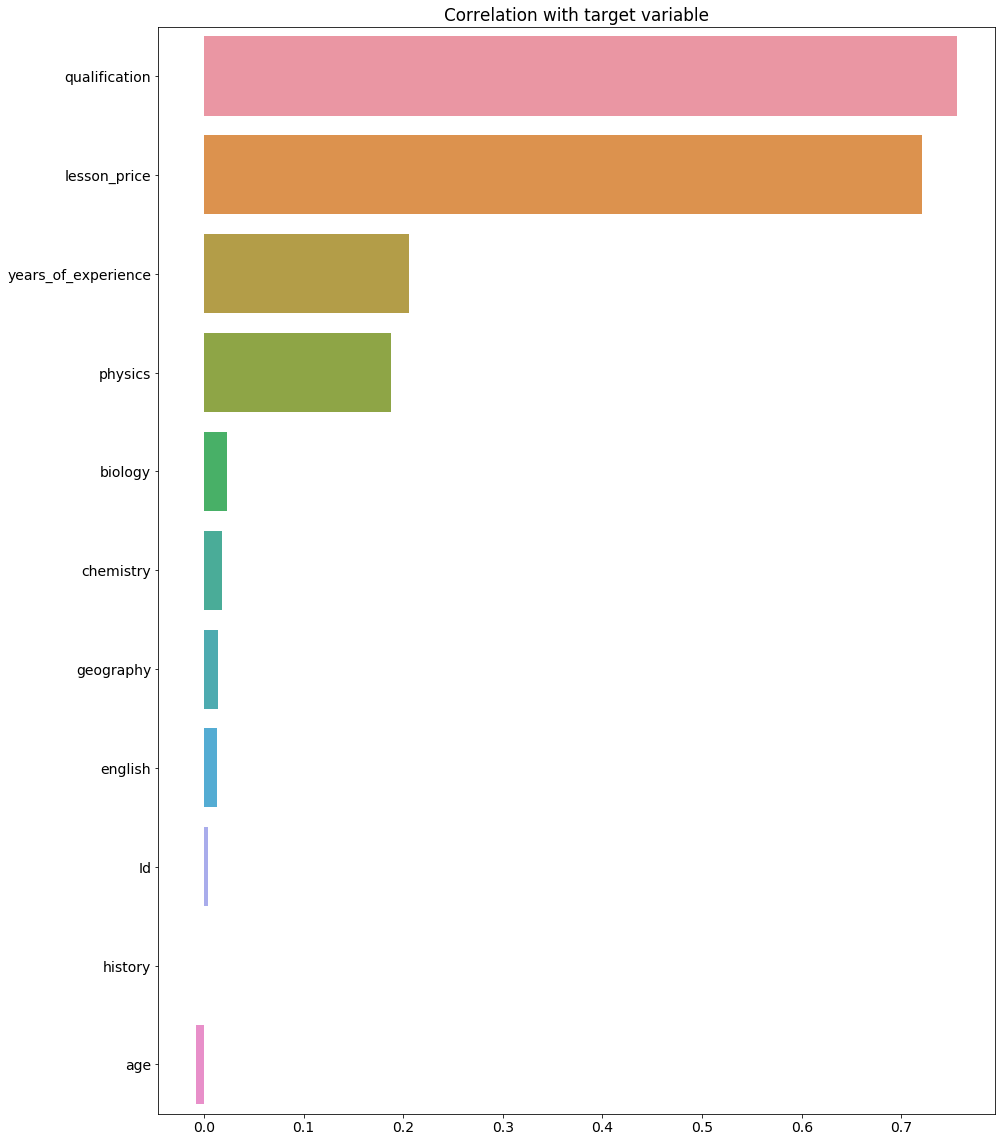

In [67]:
TARGET_NAME = 'mean_exam_points'

corr_with_target = train_df.corr()[TARGET_NAME].sort_values(ascending=False)[1:]

plt.figure(figsize=(15, 20))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

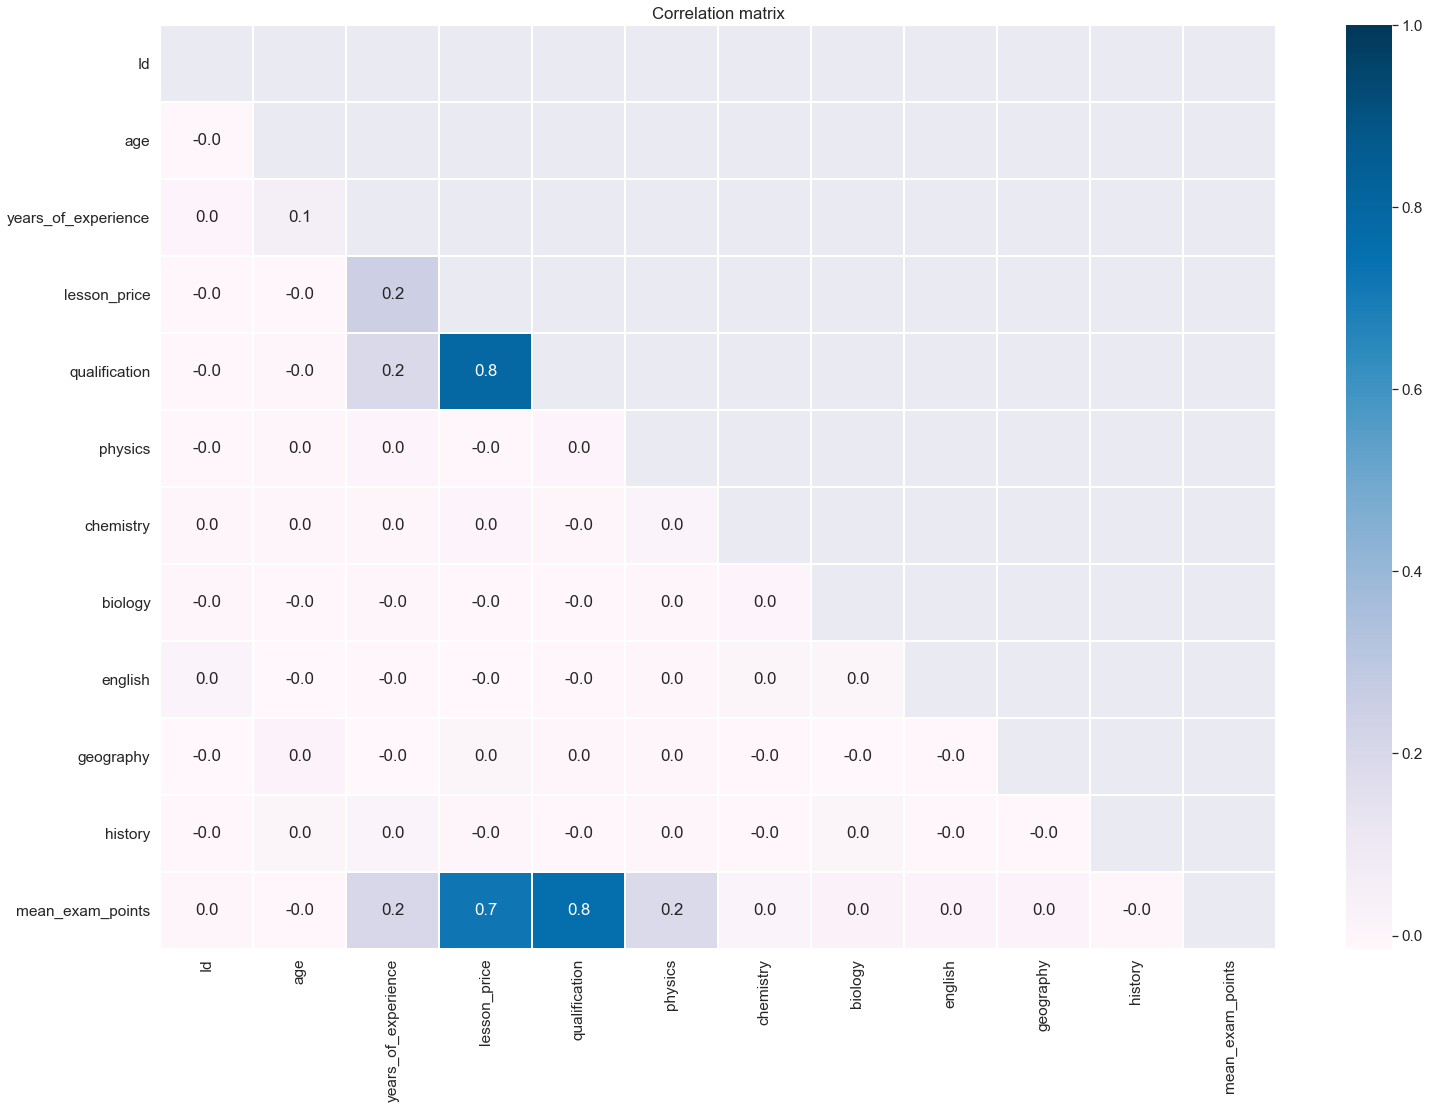

In [68]:
df_num_features = pd.get_dummies(train_df)
# df_num_features = train_df.select_dtypes(include = ['float64', 'int64'])
num_features = pd.DataFrame(df_num_features)

corr = num_features.corr()
plt.figure(figsize = (25, 17))
mask = np.zeros_like(corr, dtype=np.bool)  # отрезаем лишнюю половину матрицы
mask[np.triu_indices_from(mask)] = True
sns.set(font_scale=1.4)
sns.heatmap(num_features.corr(), mask=mask, annot=True, fmt='.1f', linewidths=.5, cmap='PuBu')
plt.title('Correlation matrix')
plt.show();

###  Графики

In [69]:
# fig, ax = plt.subplots(figsize=(24, 10))
# ax.bar(train_df['mean_exam_points'], train_df['qualification'], ec='white', label='Квалификация') # color='#CC0033'
# #set ticks every week
# #set major ticks format
# ax.set(xlabel='Средний балл',
#        ylabel='Квалификация',
#        title='Соотношение квалификации и среднего бала')
# plt.xticks(rotation=90) 
# plt.legend()
# plt.show()

In [70]:
# fig, ax = plt.subplots(figsize=(24, 10))
# ax.bar(train_df['mean_exam_points'], train_df['lesson_price'], ec='white', label='Цена урока') # color='#CC0033'
# #set ticks every week
# #set major ticks format
# ax.set(xlabel='Средний балл',
#        ylabel='Цена урока',
#        title='Соотношение цены урока и среднего бала')
# plt.xticks(rotation=90) 
# plt.legend()
# plt.show()

In [71]:
# fig, ax = plt.subplots(figsize=(24, 10))
# ax.bar(train_df['mean_exam_points'], train_df['years_of_experience'], ec='white', label='Стаж') # color='#CC0033'
# #set ticks every week
# #set major ticks format
# ax.set(xlabel='Средний балл',
#        ylabel='Стаж',
#        title='Соотношение стажа и среднего бала')
# plt.xticks(rotation=90) 
# plt.legend()
# plt.show()

### Первичный подбор модели

In [72]:
X = pd.get_dummies(train_df)
X.drop('mean_exam_points', axis=1, inplace=True)
X.drop('Id', axis=1, inplace=True)

y = train_df['mean_exam_points']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 2)

In [73]:
models = []

models.append(('CatBoostRegressor', CatBoostRegressor(silent=True)))
models.append(('RandomForestRegressor', RandomForestRegressor()))
models.append(('GradientBoostingRegressor', GradientBoostingRegressor()))
models.append(('LGBMRegressor', LGBMRegressor()))
models.append(('XGBRegressor', XGBRegressor(silent=True)))

In [74]:
results = []

for name, model in models:
    model.fit(X_train, y_train)
    y_pred_train  = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    TRR2 = r2_score(y_train, y_pred_train)
    R2 = r2_score(y_test, y_pred_test)
    MAE = mean_absolute_error(y_test, y_pred_test)
    MSE = mean_squared_error(y_test, y_pred_test)
    EV = explained_variance_score(y_test, y_pred_test)
    # print(f'R2 - {R2}, MAE - {MAE}, MSE - {MSE} - {name}')
    results.append((name, TRR2, R2, EV, MAE, MSE))
    
best_models = pd.DataFrame(results, columns = ['model', 'TRAIN - R2', 'R2', 'EV', 'MAE', 'MSE'])
best_models.sort_values('R2', ascending=False)

,model,TRAIN - R2,R2,EV,MAE,MSE
3,LGBMRegressor,0.81699,0.79149,0.79150,4.78345,40.58512
0,CatBoostRegressor,0.82963,0.79075,0.79075,4.80014,40.72887
2,GradientBoostingRegressor,0.77949,0.78731,0.78732,4.89327,41.39820
4,XGBRegressor,0.85684,0.78017,0.78017,4.91183,42.78773
1,RandomForestRegressor,0.94356,0.75456,0.75459,5.14793,47.77217


### Создание функции

In [75]:
def mega_func(df):
    # Построение новых признаков
    df['tutor_rating'] = 1
    df.loc[(df['qualification'] >= 3) & (df['years_of_experience'] >= 8), 'tutor_rating'] = 5
    df.loc[((df['qualification'] < 3) & (df['qualification'] >= 2)) & ((df['years_of_experience'] < 8) & (df['years_of_experience'] >= 6)), 'tutor_rating'] = 4
    df.loc[((df['qualification'] < 2) & (df['qualification'] >= 1)) & ((df['years_of_experience'] < 6) & (df['years_of_experience'] >= 4)), 'tutor_rating'] = 3
    df.loc[(df['qualification'] < 1) & (df['years_of_experience'] < 2), 'tutor_rating'] = 2
    df['service'] = 1
    df.loc[(df['qualification'] >= 3) & (df['lesson_price'] >= 3500), 'service'] = 5
    df.loc[((df['qualification'] < 3) & (df['qualification'] >= 2)) & ((df['lesson_price'] < 3500) & (df['lesson_price'] >= 2500)), 'service'] = 4
    df.loc[((df['qualification'] < 2) & (df['qualification'] >= 1)) & ((df['lesson_price'] < 2500) & (df['lesson_price'] >= 1500)), 'service'] = 3
    df.loc[(df['qualification'] < 1) & (df['lesson_price'] < 1000), 'service'] = 2
#     # Построение новых признаков - \(o_O)/
    df['q_lp_ratio'] =  df['qualification'] * df['lesson_price']
    df['lp_q_deratio'] =  df['lesson_price'] / df['qualification'] # -  0.7749

In [76]:
mega_func(train_df)
mega_func(test_df)

In [77]:
# train_df['tutor_rating'].value_counts()
# train_df['service'].value_counts()
# train_df['q_lp_ratio'].value_counts()

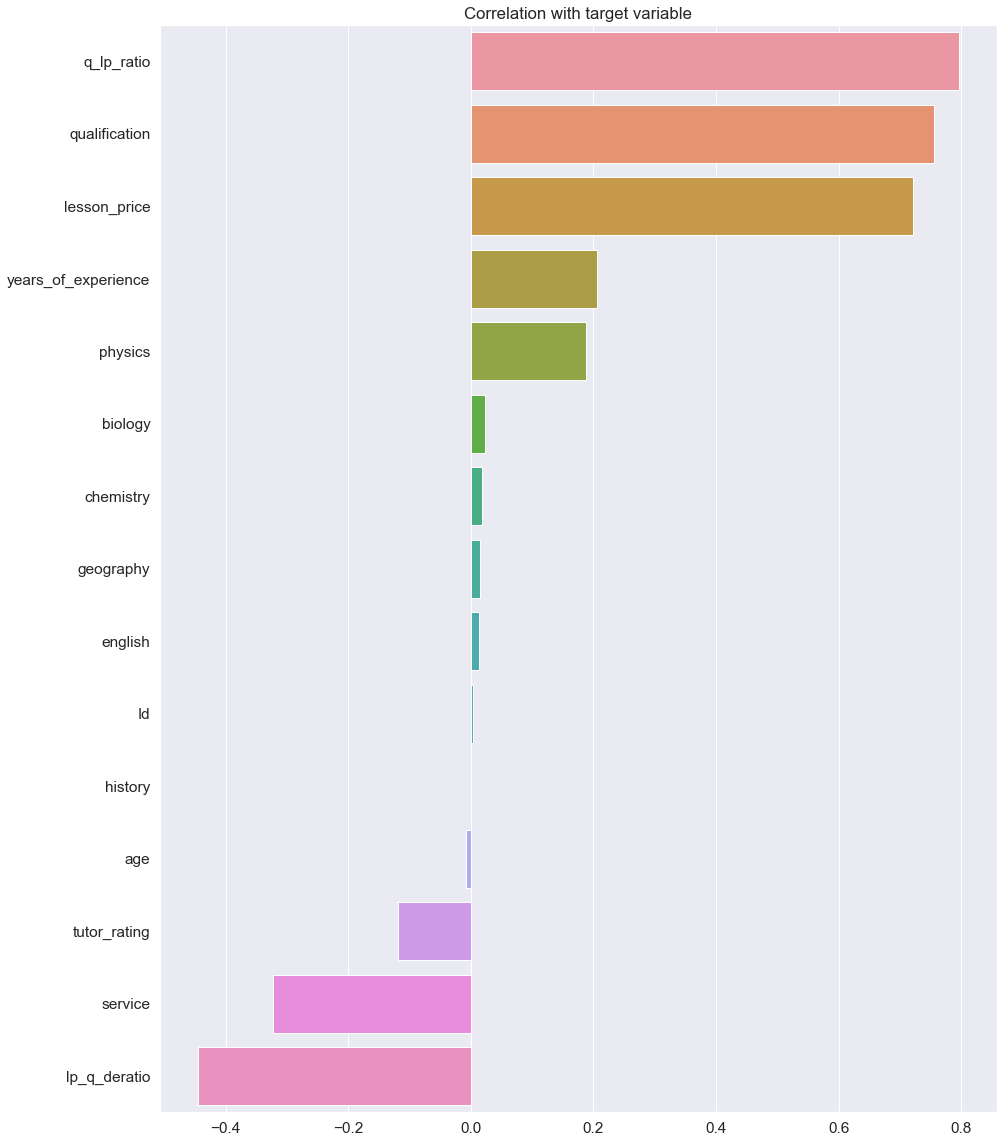

In [78]:
corr_with_target = train_df.corr()[TARGET_NAME].sort_values(ascending=False)[1:]

plt.figure(figsize=(15, 20))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

In [79]:
X = pd.get_dummies(train_df)
X.drop('mean_exam_points', axis=1, inplace=True)
X.drop('Id', axis=1, inplace=True)

y = train_df['mean_exam_points']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 2)

# Результат после добавления новых признаков
results = []

for name, model in models:
    model.fit(X_train, y_train)
    y_pred_train  = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    TRR2 = r2_score(y_train, y_pred_train)
    R2 = r2_score(y_test, y_pred_test)
    MAE = mean_absolute_error(y_test, y_pred_test)
    MSE = mean_squared_error(y_test, y_pred_test)
    EV = explained_variance_score(y_test, y_pred_test)
    results.append((name, TRR2, R2, EV, MAE, MSE))
    
best_models = pd.DataFrame(results, columns = ['model', 'TRAIN - R2', 'R2', 'EV', 'MAE', 'MSE'])
best_models.sort_values('R2', ascending=False)

,model,TRAIN - R2,R2,EV,MAE,MSE
3,LGBMRegressor,0.82107,0.79105,0.79106,4.79057,40.66997
0,CatBoostRegressor,0.83401,0.79022,0.79022,4.79027,40.83232
2,GradientBoostingRegressor,0.78611,0.79003,0.79004,4.81464,40.86812
4,XGBRegressor,0.86557,0.77505,0.77505,4.91994,43.78493
1,RandomForestRegressor,0.94321,0.75108,0.75115,5.16873,48.45070


**Автоматический подбор параметров(GridSearchCV)**

In [80]:
# estimator = GradientBoostingRegressor()
# param_grid = {
#     'n_estimators': [74],
#     'min_samples_split': [5],
#     'learning_rate': [0.1],
#     'max_depth': [4],
#     'random_state': [15]
# }

# model_gbr = GridSearchCV(estimator, param_grid, scoring='r2')
# model_gbr.fit(X_train, y_train)

# print('Best parameters found by grid search are:', model_gbr.best_params_)

In [81]:
%%time

model_gbr = GradientBoostingRegressor(learning_rate=0.1, n_estimators=74, max_depth=5, min_samples_split=5, random_state=2)
model_gbr.fit(X_train, y_train)
y_pred_train  = model_gbr.predict(X_train)
y_pred_test = model_gbr.predict(X_test)
print('GradientBoostingRegressor: r2_score(TRAIN) - ' + str(r2_score(y_train, y_pred_train)))
print('GradientBoostingRegressor: r2_score(TEST) - ' + str(r2_score(y_test, y_pred_test)))
print('GradientBoostingRegressor: MAE(TEST) - ' + str(mean_absolute_error(y_test, y_pred_test)))
print('GradientBoostingRegressor: MSE(TEST) - ' + str(mean_squared_error(y_test, y_pred_test)))

# GradientBoostingRegressor: r2_score(TEST) - 0.7798913816520958 (random_state=1)

GradientBoostingRegressor: r2_score(TRAIN) - 0.8095911460348186
GradientBoostingRegressor: r2_score(TEST) - 0.792596849791308
GradientBoostingRegressor: MAE(TEST) - 4.7629421997085695
GradientBoostingRegressor: MSE(TEST) - 40.369136184484546
Wall time: 517 ms


### Класс модели Gradient Boosting

In [82]:
# Реализуем класс узла
class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [83]:
# И класс терминального узла (листа)
class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        
        # Расчет среднего значения в листе
        prediction = np.mean(self.labels)
        return prediction 

In [84]:
# Реализуем класс дерева
class Tree:

    def __init__(self, max_depth):
        self.max_depth = max_depth
        self.tree = None


    # В случае регрессии разброс будет характеризоваться дисперсией
    def variance(self, labels):
        return np.var(labels)


    # Расчет качества
    def quality(self, left_labels, right_labels, current_variance):

        # доля выбоки, ушедшая в левое поддерево
        p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
        
        return current_variance - p * self.variance(left_labels) - (1 - p) * self.variance(right_labels)

    
    # Разбиение датасета в узле
    def split(self, data, labels, index, t):
    
        left = np.where(data[:, index] <= t)
        right = np.where(data[:, index] > t)
            
        true_data = data[left]
        false_data = data[right]
        true_labels = labels[left]
        false_labels = labels[right]
            
        return true_data, false_data, true_labels, false_labels

    
    # Нахождение наилучшего разбиения
    def find_best_split(self, data, labels):
        
        #  обозначим минимальное количество объектов в узле
        min_leaf = 5

        current_variance = self.variance(labels)

        best_quality = 0
        best_t = None
        best_index = None
        
        n_features = data.shape[1]
        
        for index in range(n_features):
            # будем проверять только уникальные значения признака, исключая повторения
            t_values = np.unique([row[index] for row in data])
            
            for t in t_values:
                true_data, false_data, true_labels, false_labels = self.split(data, labels, index, t)
                #  пропускаем разбиения, в которых в узле остается менее 5 объектов
                if len(true_data) < min_leaf or len(false_data) < min_leaf:
                    continue
                
                current_quality = self.quality(true_labels, false_labels, current_variance)
                
                #  выбираем порог, на котором получается максимальный прирост качества
                if current_quality > best_quality:
                    best_quality, best_t, best_index = current_quality, t, index

        return best_quality, best_t, best_index
    

    # Построение дерева с помощью рекурсивной функции
    def build_tree(self, data, labels, max_depth, depth=0):

        quality, t, index = self.find_best_split(data, labels)

        # Прекращаем рекурсию, когда нет прироста в качества или достигнута
        # максимальная глубина дерева
        if quality == 0 or depth >= max_depth:
            return Leaf(data, labels)

        true_data, false_data, true_labels, false_labels = self.split(data, labels, index, t)

        # Рекурсивно строим два поддерева
        true_branch = self.build_tree(true_data, true_labels, max_depth, depth+1)
        false_branch = self.build_tree(false_data, false_labels, max_depth, depth+1)

        # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
        return Node(index, t, true_branch, false_branch)
    

    def predict_target(self, obj, node):

        #  Останавливаем рекурсию, если достигли листа
        if isinstance(node, Leaf):
            answer = node.prediction
            return answer

        if obj[node.index] <= node.t:
            return self.predict_target(obj, node.true_branch)
        else:
            return self.predict_target(obj, node.false_branch)
    

    def predict(self, data):
    
        values = []
        for obj in data:
            prediction = self.predict_target(obj, self.tree)
            values.append(prediction)
        return values
    

    # Строим дерево
    def fit(self, data, labels):
        self.tree = self.build_tree(data, labels, self.max_depth)
        return self

In [85]:
# Реализуем класс для градиентного бустинга
class GB:
    def __init__(self, n_trees, max_depth, coefs, eta):
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.coefs = coefs
        self.eta = eta
        self.trees = []


    def bias(self, y, z):
        return (y - z)

    def fit(self, X_train, y_train):
        
        # Деревья будем записывать в список
        trees = []

        for i in range(self.n_trees):
            tree = Tree(max_depth=self.max_depth)         

            # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
            # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
            if len(self.trees) == 0:
                # обучаем первое дерево на обучающей выборке
                tree.fit(X_train, y_train)
            else:
                # Получим ответы на текущей композиции
                target = self.predict(X_train)
                
                # алгоритмы начиная со второго обучаем на сдвиг
                tree.fit(X_train, self.bias(y_train, target))
            self.trees.append(tree)
            
        return self
    
    
    def predict(self, X):
        # Реализуемый алгоритм градиентного бустинга будет инициализироваться нулевыми значениями,
        # поэтому все деревья из списка trees_list уже являются дополнительными и при предсказании прибавляются с шагом eta
        return np.array([sum([self.eta * coef * alg.predict([x])[0] for alg, coef in zip(self.trees, self.coefs)]) for x in X])

In [86]:
# Функция вычисления метрики R2
def R2(y_pred, y_true):
    numerator = ((y_true - y_pred) ** 2).sum(axis=0, dtype=np.float64)
    denominator = ((y_true - np.average(y_true)) ** 2).sum(axis=0, dtype=np.float64)
    return 1 - (numerator / denominator)

### Прогнозирование

In [87]:
features = ['age', 'years_of_experience', 'lesson_price', 'qualification', 'physics', 'chemistry', 'biology', 'english', 'geography', 'history', 'service'] # - 0.7776
# q_lp_ratio - 0.7758, tutor_rating - 0.7735, service - 0.7762, lp_q_deratio - 0.7732

In [88]:
X = train_df[features].values
y = train_df[TARGET_NAME].values

In [89]:
# def calc_std_feat(x):
#     res = (x - x.mean()) / x.std()
#     return res

In [90]:
# X_st = X.copy()
# X_st[2, :] = calc_std_feat(X[2, :])

In [91]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42) # - 8 0.7904214783176695

In [92]:
# Число деревьев в ансамбле
n_trees = 17

# для простоты примем коэффициенты равными 1
coefs = [1] * n_trees

# Максимальная глубина деревьев
max_depth = 5

# Шаг
eta = 0.41

In [93]:
gb = GB(n_trees, max_depth, coefs, eta)
# Обучение модели
gb.fit(X_train, y_train)
# Предскажем значения на тестовом наборе
y_pred_test = gb.predict(X_test)

In [94]:
R2(y_pred_test, y_test)

0.7770110577442296

In [96]:
gb_final = GB(n_trees, max_depth, coefs, eta)
gb_final.fit(X, y)

In [97]:
X_test = test_df[features].values

In [98]:
y_pred_test = gb_final.predict(X_test)

### Cохранение результатов

In [99]:
submissions = pd.concat([test_df['Id'], pd.Series(y_pred_test)], axis=1)
submissions = submissions.rename(columns={0: 'mean_exam_points'})

submissions.to_csv(RES_PATH, index=False, encoding='utf-8')

In [100]:
# X_test = pd.get_dummies(test_df)
# X_test.drop('Id', axis=1, inplace=True)
# test_df['mean_exam_points'] = model_gbr.predict(X_test)
# test_df['mean_exam_points'] = test_df['mean_exam_points'] #.astype('int')
# test_df.loc[:, ['Id', 'mean_exam_points']].to_csv(RES_PATH, index=False, encoding='utf-8')